TODO
=====

1. Plot more sizes. Make sure that 1000 isn't hard-coded anywhere.
4. Plot different selection amounts.
5. Re-structure paper around toolbox of methods and new visualizations.

Done
=====
1. Concurrent searches.
2. Using mode to summarize runs to a single value.
3. Graphs
    * Concurrent searches.
    * Plot the impact of the improvement from each technique separately.

Results
=====
* Why is this important? Search is well-studied, but interpolation is neglected. In-memory workloads are important, and increasingly so with data visualization platforms becoming interactive.
* Consider discussing the case where the key isn't in the array.

Key Contributions
--------------------
1. List of optimizations for binary search.
2. List of optimizations for interpolation search.
3. Characterization of interpolation search and binary search.
    * Why?
4. Concurrent search / multi-core
5. Relationship between mathematical properties of data and performance of interpolation search.
    * When to use interpolation search?

Toolbox of Methods
---------------------
Structure discussion around a compilation of effectiveness of methods. Make a table of the toolbox of methods. Show impact of each method separately. A --> B --> C
<table>
<tr><th>Method</th><th>Impact</th></tr>
<tr><td>Stop testing equality.</td><td>Remove a branch.</td></tr>
<tr><td>Don't track L+R, but L+sz.</td><td>1/2 as many cond moves.</td></tr>
<tr><td>Linear search.</td><td>Out of order execution.</td></tr>
</table>
    

Notes
====
* Now that we have a better idea of the standard deviation, are 30 samples enough?
* Concurrent search is important because it shows very small degradation in performance, but seeing a flat line is uninteresting.
* Should BS vs IS on threads be in terms of oracle?
* I'm not a fan of the box plots because they're in terms of quartiles, but I like that they show something about the distribution as well as the range. I worry that violin plots are too complicated, especially since I would be plotting standard deviation and mean on top. I think the ideal plot would show mean, stddev, and range in two dimensions (performance over threads, etc.)
* Since I'll have a graph describing the progression of each improvement. I don't need to show naive vs fast again.
* Since I have a graph showing binary vs interpolation across dataset sizes, I don't need to show the single bar chart.
* Since I'm using interpolation vs binary as units, and I will include the deviation across files in the dataset chart, I don't need the interpolation by file chart.
* Important to specify that the bars in the performance graphs describe the performance of a single algorithm, with a low amount of error on different datasets.

In [25]:
from pandas import read_csv,DataFrame,Series
from os import popen
from subprocess import call,check_output
from math import sqrt,log2
from matplotlib.pyplot import show, plot, table, subplots
from scipy.stats import linregress
from sklearn.metrics import r2_score,mean_absolute_error
from heapq import heappush,heappop
from numpy import array,fromiter,int64,histogram
from IPython.display import display
from itertools import accumulate
from collections import Counter
n_files = n_samples = 30
n_thds = 4
lg_max_sz = 5
szs = [10**x for x in range(3,lg_max_sz+1)]
szs_files = {sz: ['input/uniform.{}.{}'.format(sz, n) for n in range(n_samples)] for sz in szs}
files = ['input/uniform.1000.' + str(n) for n in range(n_files)]
bin_algs = 'binary-naive binary-size binary-linear'.split()
int_algs = 'interpolation-naive interpolation-recurse interpolation-linear-fp interpolation-linear'.split()
sz_algs = 'binary-linear interpolation-linear'.split()
algs = bin_algs + int_algs
def mode(l): return Counter(l).most_common(1)[0][0]
def matrix_norm_vec(m, v): return (v / m.T).T

# Algorithm cycles across Datasets
Interpolation, binary across Datasets

Naive v Best v Oracle on Binary, Interpolation w/ Min, Interpolation w/ Median

In [18]:
call(['make'] + ['-j{}'.format(n_thds)] + [f for sz_f in szs_files.values() for f in sz_f])

0

In [ ]:
call('make release N_SAMPLES=-1 NSORT=1',shell=True)
sz_file_alg_mode = { sz: [{alg: mode(cycles)
                            for alg, cycles in read_csv(popen('./search {} 1 {}'.format(file, ' '.join(sz_algs)))).iteritems()}
                           for file in szs_files[sz]]
                     for sz in szs}

In [8]:
call('make release N_SAMPLES=-1 NSORT=1',shell=True)
thds_files_algs_cycles = [{
    file: read_csv(popen('./search {} {} {}'.format(file,n_thd+1,' '.join(algs)))) for file in files}
    for n_thd in range(n_thds)]

In [26]:
print(list(thds_files_algs_cycles[0]['input/uniform.1000.0']))
files_cycles = DataFrame({alg: [float(mode(thds_files_algs_cycles[0][file][alg])) for file in files]
                          for alg in list(thds_files_algs_cycles[0][files[0]])},
                        index=files).sort_values('interpolation-linear')
files_stddev = Series({alg:max(
    [float(100.0*thds_files_algs_cycles[0][file][alg][2000:].std()/thds_files_algs_cycles[0][file][alg][2000:].mean())
                                for file in files])
                       for alg in list(thds_files_algs_cycles[0][files[0]])})
bin_improve = matrix_norm_vec(files_cycles[bin_algs], files_cycles['binary-naive'])
int_improve = matrix_norm_vec(files_cycles[int_algs], files_cycles[int_algs[0]])
files_cycles = matrix_norm_vec(files_cycles, files_cycles['binary-linear'])
algs_thds_cycles = { alg: DataFrame({thds+1: [mode(algs_cycles[alg])
                                              for algs_cycles in files_algs_cycles.values()]
                           for thds, files_algs_cycles in enumerate(thds_files_algs_cycles)})
                    for alg in algs
                     }
alg_sz_file_mode_ns = {alg: DataFrame({sz: Series([algs_mode[alg] for algs_mode in files_algs_mode])
                             for sz, files_algs_mode in sz_file_alg_mode.items()})
                       for alg in sz_algs}
int_sz_mode = alg_sz_file_mode_ns['binary-linear'] / alg_sz_file_mode_ns['interpolation-linear']

['binary-naive', 'binary-size', 'binary-linear', 'interpolation-naive', 'interpolation-recurse', 'interpolation-linear-fp', 'interpolation-linear']


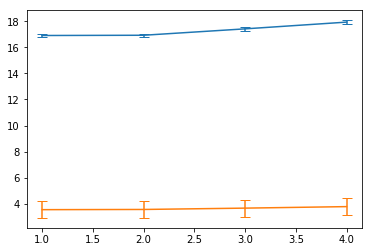

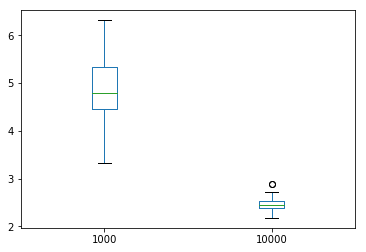

binary-linear               4.817259
binary-naive                3.639465
binary-size                 2.408995
interpolation-linear        6.545804
interpolation-linear-fp    11.784647
interpolation-naive         2.561120
interpolation-recurse       4.229775
dtype: float64

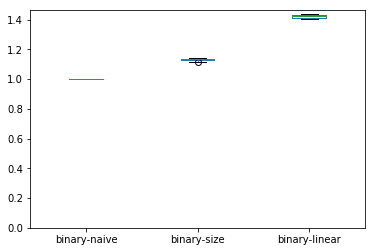

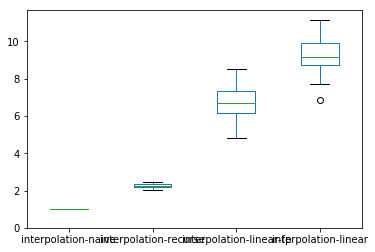

In [49]:
fig, ax = subplots()
for alg in sz_algs:
    ax.errorbar(list(algs_thds_cycles[alg]), algs_thds_cycles[alg].mean(),
               yerr=algs_thds_cycles[alg].std(), fmt='',capsize=5)
show()

int_sz_mode.plot.box()
show()

display(files_stddev)

ax = bin_improve.plot.box()
ax.set_ylim(0)
show()

ax = int_improve.plot.box()
ax.set_ylim(0)
show()
files_d = {
    'median': files_cycles.index[len(files_cycles.index)//2],
    'min': files_cycles.index[0]
} 
    
##############################
files_stddev.to_csv('stddev.csv')
# TODO replace box plots where appropiate
# https://stackoverflow.com/questions/30500280/removing-error-bar-caps-in-matplotlib
# TODO replace with plot across datasets
# TODO replace with plots across improvements
# TODO push boxplot to latex
# https://tex.stackexchange.com/questions/84541/simpler-boxplots-in-pgfplots-is-this-possible

# Distance Across Datasets

In [6]:
def read_ints(file):
    return[int(s) for s in open(file).read().splitlines()[1:]]
def interpolate(x, n, y_l, y_r):
    if n < 1: return 0
    return (x-y_l) // ((y_r - y_l)//n)
def interpolate_l(x, l):
    return interpolate(x, len(l), l[0], l[-1])

def avg(l):
    return sum(l)/len(l)
def dist(a_l, b_l):
    return [abs(a - b) for a,b in zip(a_l, b_l)]
def r2(x,y):
    m, b, r, _, _ = linregress(x,y)
    return r**2
# TODO verify this matches definition
def smoothness(nums):
    adj_dist = [abs(d) for d in dist(nums[1:], nums[:-1])]
    return max(adj_dist) / min(adj_dist)

dist_d = {}
for file in files:
    nums = read_ints(file)
    guesses = [interpolate_l(x,nums) for x in nums]
    d = sorted(dist(range(len(nums)), guesses))
    if file == files_d['median']: cdf = d
    for k,v in [('max',d[-1]),
                ('90',d[int(len(d)*.9)]),
                ('l1',avg(d)),
                ('r2', r2(range(len(nums)), guesses)),
                ('smoothness', smoothness(nums)),
                ('cycles', files_cycles['interpolation-linear'][file]),
                ('file',file)]:
        if k not in dist_d: dist_d[k] = [v]
        else: dist_d[k].append(v)
dist_d = DataFrame(dist_d).set_index('file').sort_values('l1')

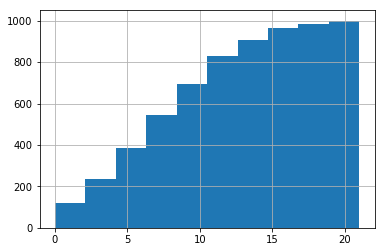

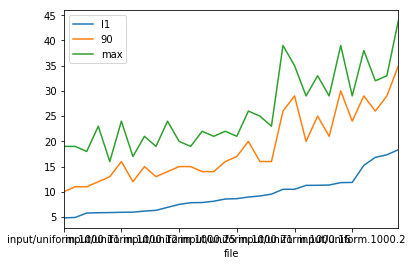

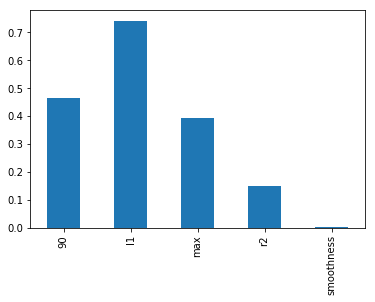

In [7]:
# do CDF in LaTeX
with open('cdf.dat','w') as f:
    f.write('\n'.join([str(v) for v in cdf]))
##############################
dist_d.reset_index().to_csv('metric.dat', sep=' ', index_label='dataset')
Series(cdf).hist(cumulative=True).plot()
dist_d[['l1','90','max']].plot()
show()

predictors = dist_d
df_predict = DataFrame(predictors, index=files)
df_predict = Series({predictor: r2(df_predict['cycles'], df_predict[predictor])
                        for predictor, prediction in predictors.items()}).drop('cycles')
df_predict.plot.bar()
##############################
df_predict.name = 'r2'
df_predict.to_csv('predict.dat', sep=' ', index_label='metric', header=True)
show()